# appunti hdf5

formato per scambio di dati autodescrittivi 

autodescrittivo: data set, eg array n dimensionale di numeri, ha metadati addizionali associati ad esso che descrivono cose come rango 
	dell'array, numero di elementi in ogni dimensione, etc
	
prende principi da programmazione orientata agli ogg

array n-dim, immagini e tabelle possono esser immagazzinati nello stesso file ma in oggetti diversi

utente può capire contenuti del file a cui accede nei termini dei vari tipi di dati oggetto hdf5, segue descriz tipi dati oggetto

## hdf5 file struct

file hdf5 = directory + collection di data obj

ogni data obj ha un entry nella directory contenente puntatore a locazione del data obj, e informazione sul datatype

++ su datatypes: https://portal.hdfgroup.org/display/HDF5/Datatype+Basics

ci sono solo due data obj fondamentali in hdf5: groups e namespaces

file hdf5 sono organizzati gerarchicamente con due strutture primarie: groups, datasets


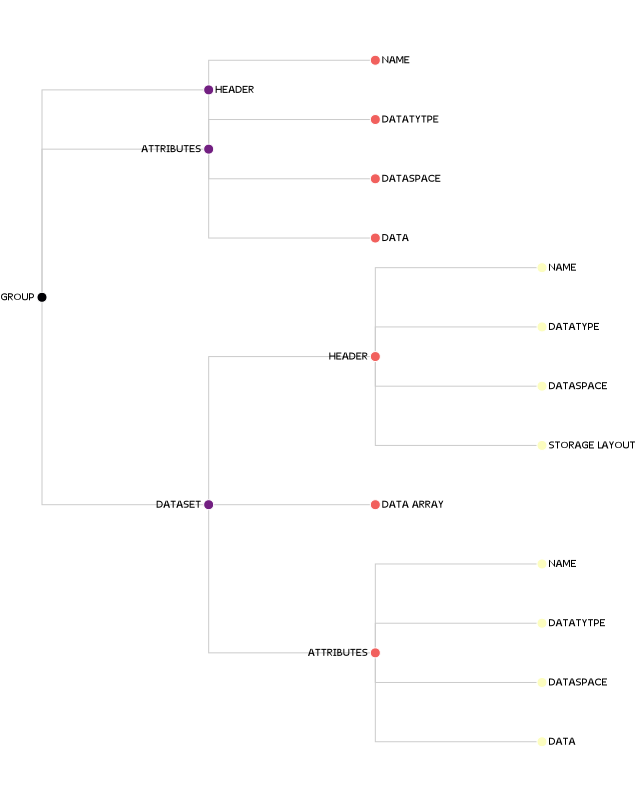

In [2]:
include("../../code/julia/drawTree.jl")
using DataFrames
using VegaLite
using CSV
mylab = CSV.read("LABELSGENERIC.txt")
drawTree.drawtree(mylab)

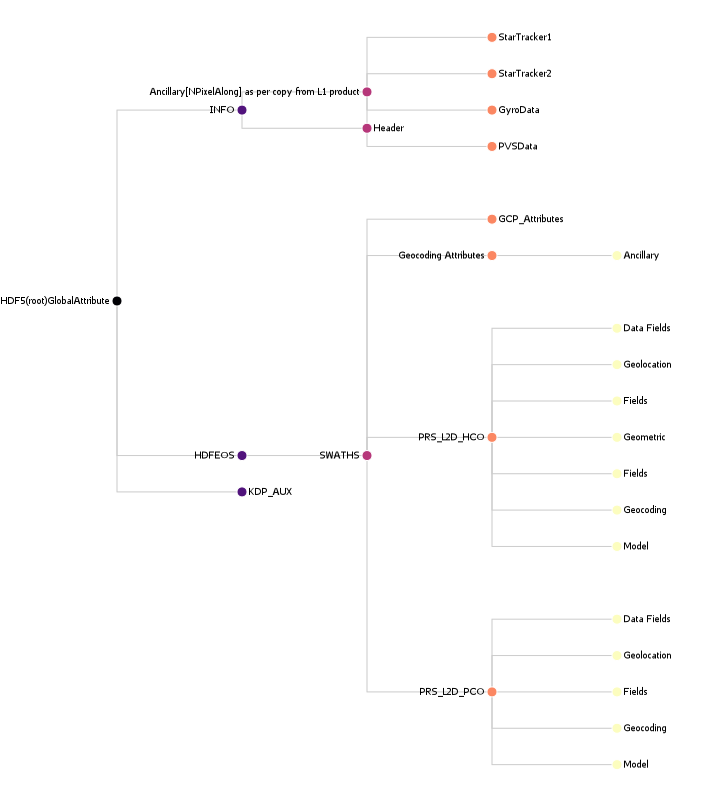

In [3]:
myasd = CSV.read("LABELSPRISMA.txt")
drawTree.drawtree(myasd)

## gruppi

un gruppo hdf5 è una struttura contenente 0 o + oggetti

ogni gruppo contiene 2 parti: 

1. header: contiene nome gruppo, lista di attributi del gruppo

2. tabella simboli: lista tutti gli oggetti hdf5 appartenenti al gruppo
    
gerarchia gruppi/membri è simile a directory/file e path in UNIX:

/ <- indica gruppo root

/foo <- indica membro foo del gruppo root

/foo/loo <- indica membro loo del gruppo foo, il gruppo foo è membro del gruppo root
    
## dataset

dataset sono array multidimensionali di dati con metadati annessi, un dataset è immagazzinato in due parti: header e data array

### dataset header

contiene informazioni necessarie all interpretazione della porzione array del dataset e metadati(o puntatori a metadati)  che descrivano o annotino il dataset.

informazioni nell'header includono: nome dell oggetto, dimensioni oggetto, number-type dell oggetto, info su come i dati stessi sono salvati a disco e ** altre informazioni usate dalla lib per velocizzare accesso dati ** o garantirne integrità

ci son 4 classi di info in ogni header:

1. nome <- sequenza di caratteri ascii alfanumerici
2. datatype <- descrive disposizione specifica dei bit del dataset, è immutabile, ci sono due categorie di datatype: dt atomico e dt composto
    
    1. datatype atomico: ogni datatype atomico appartiene a una determinata classe e possiede determinate caratteristiche come dimensioni, ordine, precisione e offset. ** documento considera solo alcune di queste caratteristiche **
        classi atomiche includono integer, float, data/ora, string, bit field, opaque. 
        proprietà integer includono dimensioni, endianità, firmatura(se il dato è stato firmato o no).
        proprietà float includono dimensioni e locazione di esponente e mantissa, locazione bit di segno.
        maggior parte delle app usano datatype predefiniti supportati dai loro compilatori, questi dt sono chiamati datatype nativi per aumentare portabilità, app dovrebbero quasi sempre usare la designazione NATIVE per descrivere valori dato in memoria. 
        architettura nativa ha nomi base che non seguono le stesse regole degli altri, nomi di tipi nativi sono simili a nomi di tipo in C
    
 2. datatype composti: collection di dt semplici, rappresentati in unità singola (simile a struct in C).
    parti di un dt composto si chiamano membri, i membri di un dt composto posson esser di qualsiasi dt, incluso altro dt composto. $ \grave{E} $ possibile lettura singola di un membro senza leggere il resto del dt composto.
    in genere ogni dataset ha il proprio datatype ma si può usare un named datatype per condividere datatype tra + dataset.
    named dt è immagazzinato nel file indipendentemente da ogni dataset ed è referenziato da ogni dataset che seguono quel tipo.
    named dt possono avere una lista attributi
    NB: named datatype => committed datatype, han cambiato terminologia
    @ hdf5 user guide https://portal.hdfgroup.org/display/HDF5/HDF5+User+Guides p18, p173+
    

3. dataspace <- descrive dimensionalità del dataset, le dimensioni di un dataset possono essere fisse o illimitate (quindi estendibili), è una lista di dimensioni con le grandezze correnti e massime(se dataset illimitato gradezza massima è settata al valore dato dalla variabile interna H5P_UNLIMITED), contiene anche rango(numero di dimensioni) del data array.
    dataspace può definire partizioni dati per poter svolgere operazioni di i/o solo su parti selezionate.
    dato un dataset n-dimensionale si possono fare selezioni parziali in 4 modi: 
        1. selezionando hyperslab n-dimensionali logicamente contigui, 
        2. seleziona hyperslab non logicamente contigui consistenti di blocchi d elementi(hyperslab) equidistanti, 
        3. seleziona un unione di hyperslab, 
        4. seleziona lista di punti indipendenti
    hyperslab: hyperslab in hdf5 è un pattern rettangolare definito da 4 array  
    vedi anche http://davis.lbl.gov/Manuals/HDF5-1.8.7/UG/12_Dataspaces.html         
    https://support.hdfgroup.org/HDF5/Tutor/select.html per tutorial
    
| Parametro	| Descrizione |
|---|---|
| Offset	| The starting location for the hyperslab.| 
| Stride	| The number of elements to separate each element or block to be selected.| 
| Count	| The number of elements or blocks to select along each dimension.| 
| Block	| The size of the block selected from the dataspace.| 
    
4. storage layout <- continuo per default (salvato linearmente allo stesso modo di come viene organizzato in memoria)
    esistono 2 altri layout definit al momento in hdf5: 
    1. compact: usato quaqndo l'ammontare di dati è piccolo da poter esser immagazzinato direttamente nell'object header
    2. chunked: divisione del dataset in pezzi equidimensionali salvati separatamente, ha tre benefici:         
        1. permette buona performance quando si accede a sottoinsiemi dei dataset, anche quando sottoinsieme da sciegliere è ortogonale al normale accesso del dataset.
        2. permette di comprimere dataset grandi pur mantenendo buone prestazioni quando si accede a parti del dataset
        3. permette di aumentare efficientemente le dimensioni del dataset in ogni direzione

            
## attributi HDF5

un attributo hdf5 è un piccolo dataset con nome che può essere allegato a dataset primari, gruppi o named datatype
è un piccolo oggetto di metadati che descrive natura o uso previsto di un oggetto dati primario.
è diviso in due parti: nome, value(che contiene data entry dello stesso data type)

gli attribvuti son assunti molto piccoli quindi son sempre  storati nell'header dell oggetto a cui si riferiscono. attributi hdf5 sono quindi gestiti tramite interfaccia di attribuyti speciale: H5A, ideata per allegare facilmente attributi a data obj primary come dataset di metadati e a minimizzare requisiti di storaggio.
attributi, per l'accesso, possono essere identificati tramite nome o indice. uso di indice permette di iterare tutti gli attributi di un determinato data object.     
     
   
    





++ sunto contenuto prodotti dei 3 livelli del prisma http://prisma-i.it/index.php/en/data-access/89-data-access/115-prisma-data-access-description 

# hdf-eos5
hdf-eos5 è un estensione a hdf che stabilisce standard per storare dati eos(earth observing system) ed aggiunge 4 datatypes
ogni datatype nuyovo è combinazione di datatype hdf5 standard ed è  servito da una api propria.
la libreria hdf-eos5 è la somma di queste API

EDF-EOS5 estende HDF5 dando le seguenti features:

1. un modo per immagazzinare dati geolocati in remote sensing missions definendo 4 datatipi nuovi composti di oggetti hdf5 standard:
    1. Point interface: per dati con informazioni geolocate annesse ma che non hanno organizzazione spaziale o temporale ben definita
    2. Swath interface: per data ordinata nel tempo come satellite swath(serie di scanlines ordinate nel tempo) o profilers
    3. Grid interface: per dati organizzati in maniera rettilinea su proiezione ben definita e supportata esplicitamente
    4. Zonal Average interface: per dati non associati a informazioni geolocate specifiche

2. un modo per fornire servizi di search su tutto il sistema: software di operazione scrive metadati speciali che riassumono informazioni spaziotemporali, qualità e stato di produzione dei dati prodotti. 
    l'insieme completo dei metadati è scritto nei file prodotto in un attributo globale come blocco testo continuo. ovvero i vari campi non son scritti come attributi singoli ma il totale di tutti i campi è scritto come singolo attributo
    
3. 4 nuovi tipi di attributo
    1. attributi globali: si riferiscono a tutto il contenuto del file hdf5
    2. attributi oggetto: si riferiscono ad un oggetto specifico
    3. attributi gruppo: si riferiscono ad un gruppo specifico
    4. attributi locali: sono attributi di campo riferiti a un campo dati (data field)
    
## datatipo Swath

il PRISMA  cattura immagini in maniera pushbroom raccogliendo informazioni(scan lines) ordinate temporalmente su un campo di vista che si muove lungo una direzione(traccia) perpendicolare alle scan line stesse.
il dt swath è ideato per storare informazioni di questo tipo quindi il livello1 usa questo dt per raccogliere esprimere dati

lo scopo del dt swath è il mappare dati scientifdici a punti specifici sulla superficie della terra. lo swath consiste di 4 parti: 

1. data fields: parte principale degli swath dal punto di vista scientifico. contengono generamente dati grezzi (spesso contatori) presi dal sensore o parametri derivati da quei dati su base personale del valore. tutti gli altri dati dello swath servono o a fornire informazioni su data field o a supportare particolari tipi di accesso ad essi. sono generalmente array con 1-8 dimensioni, in genere 2. possono essere in qualsiasi tipo di C
2. campi di geolocazione: permettono allo swath di essere localizzato precisamente rispetto alla supoerfice della terra. per far ciò l'iterfaccia swath richiede la presenza di coppie di campi longitudinali/latitudinali ("Latitude" e “Longitude”), questi campi possono essere in una o due dimensioni ed avere qualiasi tipo
3. dimensioni: le dimensioni definiscono gli assi deicampi dati e geolocazione dandogli nome e grandezze. ogni asse di ogni campo dati/geoloc deve quindi avere un campo dimensione associato
4. mappe di dimensione: definiscono, uno a uno, la relazione tra ogni dimensione di ogni campo geoloc con la dimensione corrispettiva in ogni campo dati. quando le dimenisoni di dati e geoloc differiscono, la relazione tra essi è definita da campi offset e increment

in hdf-eos5 è anche supportata la spezzettatura degli swath, cosa necessaria alla definizione di swath estendibili



++ toolkit hdf eos : https://wiki.earthdata.nasa.gov/display/DAS/Toolkit+Downloads

++ intro a hdf5 http://davis.lbl.gov/Manuals/HDF5-1.8.7/H5.intro.html

## compilazione hdf eos5
### prereq
1. libjpeg.lib : http://libjpeg.sourceforge.net/
2. zlib.lib (or zdll.lib) : https://zlib.net/
3. szlib.lib : https://www.szlib.com/en/Home/Content?catId=90&articleId=37361
3. hdf5.lib, hdf5_hl.lib, hdfeos5.lib, hdf5_fortran.lib, hdf5_hl_fortran.lib : https://www.hdfgroup.org/downloads/hdf5/
4. gctp.lib : https://github.com/tdanckaert/GCTP

## "Additional Dependencies":
### Swath & Point:
wsock32.lib hdfeos5.lib hdf5_hl.lib hdf5.lib libjpeg.lib zdll.lib szlib.lib

### Grid
wsock32.lib hdfeos5.lib gctp.lib hdf5_hl.lib hdf5.lib libjpeg.lib zdll.lib szlib.lib
### The following libraries may (or may not) need to be included: 
kernel32.lib user32.lib gdi32.lib winspool.lib comdig32.lib advapi32lib shell32.lib ole32.lib oleaut32.lib uuid.lib odbc32.lib odbccp32.lib

NOTE: hdfeos5.lib and gctp.lib are Release Versions. hdfeos5d.lib and gctpd.lib are Debug versions.

# installazione hdf eos5 da windows

# installazione hdf eos5 da windows
1. scarica toolkit SDPTK da https://wiki.earthdata.nasa.gov/display/DAS/Toolkit+Downloads
2. info su install sono a https://git.earthdata.nasa.gov/rest/git-lfs/storage/DAS/sdptoolkit/b233846c983d7a9c2d26f4800f1c43f00e0ea243ea97bb31426aa9f52bf9ec40?response-content-disposition=attachment%3B%20filename%3D%22UG.pdf%22%3B%20filename*%3Dutf-8%27%27UG.pdf
3. gli script sono bash script, per lanciarli da win serve WSL, vedi https://www.thewindowsclub.com/how-to-run-sh-or-shell-script-file-in-windows-10
4. ~Error: In 64-bit linux platform the env. variable LINUX_BRAND must be et to linux32 or linux64 before running this script.~
5. ~no~

1. ~enable wsl2, reboot~
2. ~microsoft store -> search linux -> ubuntu -> install/get app~
3. ~start -> ubuntu -> installing this might take a few minutes~
4. ~no~

1. ~apri INSTALL-HDF~
2. ~ctrl+f LINUX_BRAND~
3. ~elimina/edita~
4. ~serve hdf-4.2.13.tar.gz da https://support.hdfgroup.org/ftp/HDF/releases/HDF4.2.13/src/~
5. ~da cmd prompt:~
 1. ~cd a cartella TOOLKIT/bin~
 3. ~# bash INSTALL-HDF~
 4. ~installl fallisce se ci sono spazi nella path~~
1. cd a path del toolkit
2. bash bin/INSTALL
3. serve zlib da https://zlib.net/
4. make: not found Run of 'make' failed.
5. serve make https://stat545.com/make-windows.html
 1. installa da https://sourceforge.net/projects/gnuwin32/files/make/3.81/make-3.81.exe/download?use_mirror=deac-fra&download=
 2. aggiungi path della cartella bin di quel che hai installato (default C:\Program Files (x86)\GnuWin32\bin) a env var PATH
6. bash bin/INSTALL
7. make: not found
8. http://gnuwin32.sourceforge.net/packages/zlib.htm
9. https://github.com/horta/zlib.install
10. mancano ancora cose...
11. installa "Desktop development with C++" dal setup pacchetti di visual studio (trovabile in new project -> altro)
6. bash bin/INSTALL
7. make: not found


## install hdf
1. scarica bin da https://www.hdfgroup.org/downloads/hdf5/
2. estrai
3. installa HDF5-1.12.0-win64.msi
4. fine